In [1]:
import os
from pathlib import Path
from joblib import Parallel, delayed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, Input, Lambda, RandomBrightness, RandomContrast, RandomHue, RandomSaturation
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers import SKLearnRegressor
from tensorboard.backend.event_processing import event_accumulator
from collections import Counter


# Data

In [2]:
# pass thru tf to convert paths to images
def preprocess_image(file_path, label):
    # final_path_file = data_dir+"/"+file_path
    img = tf.io.read_file(file_path)
    # rgb, later we normalize
    img = tf.image.decode_image(img, channels=3)
    # todo: make it optional passing to grayscale
    if grayscale:
        img = tf.image.rgb_to_grayscale(img)
        img.set_shape([None, None, 1])
    else:
        img.set_shape([None, None, 3]) #rgb
    img = tf.image.resize(img, image_size)
    return img, tf.one_hot(label, depth=len(class_names))

In [3]:
data_dir = "../data"
original_size = (300,200)
image_size = (25, 25)
batch_size = 32

file_paths = []
labels = []
class_names = os.listdir(data_dir)
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = f"{data_dir}/{class_name}"
    images = sorted(os.listdir(class_dir))
    for img_path in images:
        file_paths.append(class_dir + "/" + str(img_path))
        labels.append(class_to_index[class_name])

file_paths = np.array(file_paths)
labels = np.array(labels)
grayscale = False

# todo: this can be better...
if grayscale:
    dimension = 1
else:
    dimension = 3

X_train, X_val, y_train, y_val = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)


# for CV
cv_train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
cv_train_set = cv_train_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
cv_train_set = cv_train_set.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05)    
])

cv_train_set = cv_train_set.map(lambda x, y: (data_augmentation(x, training=True), y))


X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=0.5,
    stratify=y_val,
    random_state=42
)

cv_test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
cv_test_set = cv_test_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
cv_test_set = cv_test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

cv_val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
cv_val_set = cv_val_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
cv_val_set = cv_val_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:
def count_label_distribution(dset):
    label_array = [x[1] for x in dset]
    
    labels_in_dset = []
    for x in label_array:
        labels_in_dset.extend(np.argmax(x, axis = 1))
    
    return len(labels_in_dset), Counter(labels_in_dset)
    

In [5]:
total_cv_train, cv_train_label_count = count_label_distribution(cv_train_set)
total_cv_val, cv_val_label_count = count_label_distribution(cv_val_set)
total_cv_test, cv_test_label_count = count_label_distribution(cv_test_set)


In [6]:
cv_train_label_count,cv_val_label_count,cv_test_label_count

(Counter({np.int64(2): 600, np.int64(1): 581, np.int64(0): 569}),
 Counter({np.int64(2): 75, np.int64(1): 73, np.int64(0): 71}),
 Counter({np.int64(2): 75, np.int64(0): 72, np.int64(1): 72}))

In [7]:
len(file_paths)

2188

# Overview

In [8]:
# # vertical here should only make sense since images are right-oriented
# seed_da = 42
# data_augmentation = Sequential([
#     RandomFlip("vertical",seed = seed_da),
#     RandomRotation(0.05, seed = seed_da),
#     RandomZoom(0.05, seed = seed_da)
# ])

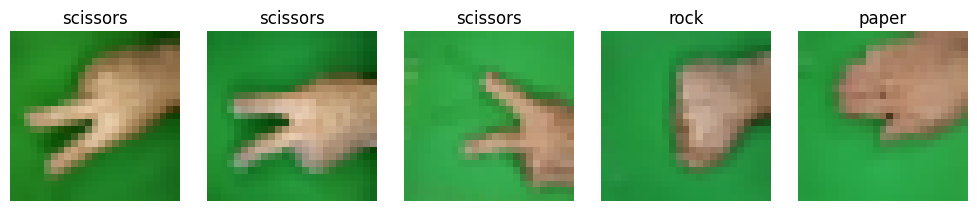

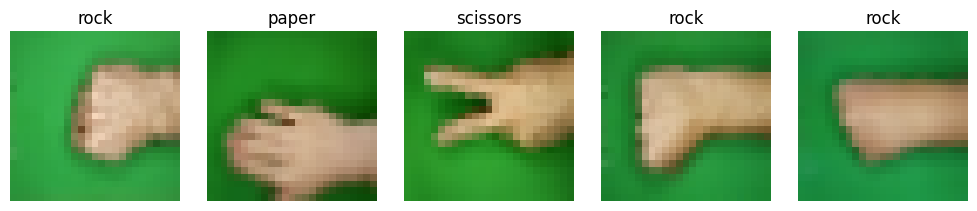

In [9]:
for images, label in cv_train_set.take(2):
    # augmented_images = data_augmentation(images)

    num_images = 5
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        # original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Model

In [10]:
def update_new_best_params(base_dict, new_params):
    cbd = base_dict.copy()
    cbd.update(new_params)
    
    return cbd

In [11]:
def show_misclassified_images(model, dataset, class_names, n=9):
    import numpy as np

    images = []
    true_labels = []
    pred_labels = []

    for img_batch, label_batch in dataset.unbatch().batch(1).take(1000):
        preds = model.predict(img_batch, verbose=0)
        pred_class = tf.argmax(preds[0])
        true_class = tf.argmax(label_batch[0])

        if pred_class != true_class:
            images.append(img_batch[0].numpy())
            true_labels.append(class_names[true_class.numpy()])
            pred_labels.append(class_names[pred_class.numpy()])

        if len(images) >= n:
            break

    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)

        img = images[i]
        if img.max() <= 1.0:
            img = img * 255.0
        img = np.clip(img.astype("uint8"), 0, 255)

        plt.imshow(img)
        plt.title(f"true: {true_labels[i]}\npred: {pred_labels[i]}", color='red')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [12]:
def show_filters(model, layer_number = 2):
    filters, biases = model.layers[2].get_weights()

    # normalize
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[3]
    grid_size = 32
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

    for i in range(grid_size * grid_size):
        ax = axs[i // grid_size, i % grid_size]
        ax.axis('off')
        
        if i < n_filters:
            f = filters[:, :, :, i]
            if f.shape[2] == 3:  # if rgb
                ax.imshow(f)
            else:  # grayscale
                ax.imshow(f[:, :, 0], cmap='gray')
        else:
            ax.set_visible(False)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [13]:
which_model = "first_architecture"

def root_logdir(architecture_name):
    return os.path.join(os.curdir, "logs\\"+architecture_name)

def get_run_logdir(architecture_name, it):
    import time
    run_id = str(it) +"_"+ time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return run_id, os.path.join(root_logdir(architecture_name), run_id)

def table_from_history(history_table, run_id):
    dft = pd.DataFrame(history_table)
    dft['run'] = run_id
    dft = dft.reset_index(names = "epoch")
    return dft 

In [14]:
def pass_batchs_to_arrays(dset, pass_dummy = False):

    X_list = []
    y_list = []

    for x_batch, y_batch in dset:
        X_list.append(x_batch.numpy())
        y_list.append(y_batch.numpy())

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    
    if pass_dummy:
        y = np.argmax(y, axis = 1)
    
    return X, y


In [15]:
def compute_classification_metrics(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    str_summary = classification_report(y_true, y_pred, target_names=class_names)
    print(str_summary)
    
    # todo: manually compute other metrics
    return cm

In [16]:
def plot_conf_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.show()

In [17]:
def evaluate_combination(i_p, params, X_train_array, y_train_array, skf, build_model):
    history_tables = []
    
    print(f"params: {params}")
    print("-" * 10)

    for i, (train_i, val_i) in enumerate(skf.split(X_train_array, y_train_array)):
        fold = f"Fold{i+1}"
        X_train, y_train = X_train_array[train_i], y_train_array[train_i]
        X_val, y_val = X_train_array[val_i], y_train_array[val_i]

        # model = build_first_model(**params)
        model = build_model(**params)
        run_id, run_logdir = get_run_logdir("first_architecture", f"ip_{i_p}"+fold)

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=30, verbose=0)

        history_tables.append(table_from_history(history.history, run_id))

    df_history = pd.concat(history_tables)
    best_train_val = df_history.groupby('run').apply(
        lambda x: x.loc[x["val_loss"].idxmin()],
        include_groups=False
    ).reset_index()

    val_loss = best_train_val['val_loss'].mean()
    val_accuracy = best_train_val['val_accuracy'].mean()

    return {
        'index': i_p,
        'params': params,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }


In [18]:
def CNN_GridSearchCV_non_parallel(X_train_array, y_train_array, param_grid, random_state, n_splits = 5, shuffle = True):

    mean_scores = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle = shuffle, random_state=random_state)

    param_combinations = [
        dict(zip(param_grid.keys(), values))
        for values in itertools.product(*param_grid.values())
    ]

    for i_p, params in enumerate(param_combinations):
        
        history_tables = []
        print("params: " + str(params))
        print("-"*10)
        # iterate first through each of the folds (with tuning)
        for i, (train_i, val_i) in enumerate(skf.split(X_train_array, y_train_array)):
            fold = f"Fold{i+1}"
            # print(fold)
            
            # data
            X_train, y_train = X_train_array[train_i], y_train_array[train_i]
            X_val, y_val = X_train_array[val_i], y_train_array[val_i]
            
            model = build_first_model(**params)
            
            # if we want to later check CV results
            run_id, run_logdir = get_run_logdir("first_architecture", f"ip_{i_p}"+fold)
            
            history = model.fit(X_train, y_train, validation_data=(X_val,y_val), 
                                epochs=30, verbose = 0)
            
            history_tables.append(table_from_history(history.history, run_id))
        
        df_history = pd.concat(history_tables)
        # same as best_model_checkpoint / checks the epoch where the model had its lowest loss
        best_train_val = df_history.groupby('run').apply(lambda x: x.loc[x["val_loss"].idxmin()], include_groups = False).reset_index()
        
        val_loss, val_accuracy = (best_train_val['val_loss'].mean(), best_train_val['val_accuracy'].mean())
        mean_scores.append((val_loss, val_accuracy))
        
        # print("-"*10)
        if i_p == 0:
            best_params = params
            best_accuracy = val_accuracy
        else:
            if val_accuracy > best_accuracy:
                best_params = params
                best_accuracy = val_accuracy
                print(f"*new_best | score: {val_accuracy}")
        print(" ")
    return best_params, best_accuracy, mean_scores
    

In [19]:
def CNN_GridSearchCV(X_train_array, y_train_array, param_grid, build_model,random_state, n_splits=5, shuffle=True, n_jobs=1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    param_combinations = [
        dict(zip(param_grid.keys(), values))
        for values in itertools.product(*param_grid.values())
    ]

    # if 1 then it's sequential
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_combination)(i, params, X_train_array, y_train_array, skf, build_model)
        for i, params in enumerate(param_combinations)
    )

    best_result = max(results, key=lambda r: r['val_accuracy'])
    best_params = best_result['params']
    best_accuracy = best_result['val_accuracy']

    mean_scores = [(r['val_loss'], r['val_accuracy']) for r in results]

    return best_params, best_accuracy, mean_scores


In [20]:
def save_params(run_logdir, name, best_params):
    with open(run_logdir + '\\' + name, 'wb') as f:
        pickle.dump(best_params, f)
        
def load_params(run_logdir):
    with open(run_logdir, 'rb') as f:
        loaded_params = pickle.load(f)
    
    return loaded_params 

## First

In [21]:
normalization_layer = Rescaling(1./255)

def build_first_model(n_filters = 64, n_neurons = 64, learning_rate = 1e-2, momentum = 0.0, 
                      kernel_size = 3, pool_size = 2, sparse = True, **kwargs):
    
    #todo: true/false data augmentation
    model = Sequential([
    Input(shape = (image_size[0], image_size[1], dimension)),
    normalization_layer,
    Conv2D(n_filters, kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Flatten(),
    Dense(n_neurons, activation="relu"),
    Dense(3, activation = "softmax")
                    ])
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    
    loss = "categorical_crossentropy"
    if sparse:
        loss = "sparse_categorical_crossentropy"
    model.compile(loss = loss,
        optimizer = optimizer,
        metrics = ["accuracy"])
    
    return model

In [22]:
X_train_array, y_train_array = pass_batchs_to_arrays(cv_train_set, pass_dummy=True)

In [23]:
param_grid = {"learning_rate": [1e-2, 1e-3, 1e-4],
              "momentum": [0.0, 0.9],
              "kernel_size": [3,5],
              "n_filters": [64, 128],
              "n_neurons": [64, 128]}

In [24]:
best_params, best_accuracy, mean_scores  = CNN_GridSearchCV(X_train_array, y_train_array, param_grid, build_first_model, 42, 5, n_jobs = -1)

KeyboardInterrupt: 

In [76]:
best_params, best_accuracy

({'learning_rate': 0.01,
  'momentum': 0.9,
  'kernel_size': 5,
  'n_filters': 128,
  'n_neurons': 64},
 np.float64(0.9788571357727051))

In [25]:
run_id, run_logdir = get_run_logdir("first_architecture", "1")

In [ ]:
save_params(best_params, "best_params_first_model.pkl")

model_checkpoint = ModelCheckpoint(run_logdir +"\\first_model.keras", save_best_only=True)
tensorboard_cb = TensorBoard(run_logdir)
early_stopping = EarlyStopping(patience = 10, restore_best_weights=True)


model = build_first_model(**best_params, sparse= False)
# here we can save the best model
model.fit(cv_train_set, validation_data=cv_val_set, epochs=100, callbacks= [tensorboard_cb,model_checkpoint, early_stopping])

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4782 - loss: 1.0309 - val_accuracy: 0.7580 - val_loss: 0.6180
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7755 - loss: 0.6167 - val_accuracy: 0.9041 - val_loss: 0.3326
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8666 - loss: 0.3861 - val_accuracy: 0.9178 - val_loss: 0.2568
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9119 - loss: 0.2578 - val_accuracy: 0.9178 - val_loss: 0.2188
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9331 - loss: 0.1933 - val_accuracy: 0.9543 - val_loss: 0.1682
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9413 - loss: 0.1772 - val_accuracy: 0.9452 - val_loss: 0.1341
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9498 - loss: 0.1394 - val_accuracy: 0.9041 - val_loss: 0.2384
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9476 - loss: 0.1598 - val_accuracy: 0.9726 - 

In [122]:
model.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9655 - loss: 0.0830 


[0.09145935624837875, 0.9634703397750854]

In [27]:
run_logdir

'.\\logs\\first_architecture\\1_run_2025_08_13-10_23_52'

In [57]:
# path_first = 'C:/Users/faarc/OneDrive/Escritorio/projects/paper_rock_scissors_pr/rock_paper_scissors/rps_deep/notebooks/logs/first_architecture/1_run_2025_07_19-15_54_58/first_model.keras'
path_first = 'C:/Users/faarc/OneDrive/Escritorio/projects/paper_rock_scissors_pr/rock_paper_scissors/rps_deep/notebooks/logs/first_architecture/1_run_2025_07_19-15_54_58'

In [ ]:
# best_model = tf.keras.models.load_model(run_logdir +"\\first_model.keras")
best_model = tf.keras.models.load_model(path_first + '/first_model.keras')

best_model.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9655 - loss: 0.0830  


[0.09145935624837875, 0.9634703397750854]

In [58]:
load_params(path_first+'/best_params_first_model.pkl')

{'learning_rate': 0.01,
 'momentum': 0.9,
 'kernel_size': 5,
 'n_filters': 128,
 'n_neurons': 64}

In [37]:
best_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 25, 25, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,379,272 (9.08 MB)

 Trainable params: 1,189,635 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,189,637 (4.54 MB)

## Second

In [ ]:
normalization_layer = Rescaling(1./255)

# using the best params from last model but with adam default learning rate: good results, comparable to before
# pool size tends to do well in size 5, tried [2,3,5]
# [64, 128] filters and neurons tried, 64 is best
# momentum (beta_1) is the same, beta_2 is better at 0.99 for [0.99, 0.999]

# sdg is better than adam in this case
base_params_second_model = {'n_filters': 128, 'n_neurons': 64, 'learning_rate': 1e-3, 'dropout_rate': 0.5,
'kernel_size': 5, 'pool_size': 2, 'momentum': 0.9, 'beta_2': 0.99, "conv_layer_factor": 1}

def build_second_model(n_filters = 128, n_neurons = 64, learning_rate = 1e-2, dropout_rate = 0.5, conv_layer_factor = 1, 
                      kernel_size = 5, pool_size = 2, sparse = True, momentum = 0.9, beta_2 = 0.99 ,**kwargs):
    
    #todo: true/false data augmentation
    print(dimension)
    model = Sequential([
    Input(shape = (image_size[0], image_size[1], dimension)),
    normalization_layer,
    Conv2D(n_filters, kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Conv2D(int(n_filters*conv_layer_factor), kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Flatten(),
    Dense(n_neurons, activation="relu"),
    Dropout(dropout_rate),
    Dense(int(n_neurons/2), activation="relu"),
    Dropout(dropout_rate),
    Dense(3, activation = "softmax")
                    ])
    
    # optimizer = Adam(learning_rate=learning_rate, beta_1=momentum, beta_2=beta_2)
    optimizer = SGD(learning_rate = learning_rate, momentum = momentum)
    
    loss = "categorical_crossentropy"
    if sparse:
        loss = "sparse_categorical_crossentropy"
    model.compile(loss = loss,
        optimizer = optimizer,
        metrics = ["accuracy"])
    
    return model

In [81]:
param_grid = {'learning_rate': [1e-2, 1e-3],
              'conv_layer_factor': [2],
              "momentum": [0.9, 0.95],
              "beta_2": [0.99],
              "pool_size": [5],
              "kernel_size": [5],
              "n_filters": [128],
              "n_neurons": [64]}

In [82]:
best_params, best_accuracy, mean_scores  = CNN_GridSearchCV(X_train_array, y_train_array, param_grid, build_second_model, 42, 5, n_jobs = -1)

In [84]:
best_params, best_accuracy

({'learning_rate': 0.01,
  'conv_layer_factor': 2,
  'momentum': 0.9,
  'beta_2': 0.99,
  'pool_size': 5,
  'kernel_size': 5,
  'n_filters': 128,
  'n_neurons': 64},
 np.float64(0.991428554058075))

In [85]:
run_id, run_logdir = get_run_logdir("second_architecture", "2")

In [86]:
model_checkpoint = ModelCheckpoint(run_logdir +"\\second_model.keras", save_best_only=True)
tensorboard_cb = TensorBoard(run_logdir)
early_stopping = EarlyStopping(patience = 10, restore_best_weights=True)


model = build_first_model(**best_params, sparse= False)
# here we can save the best model
model.fit(cv_train_set, validation_data=cv_val_set, epochs=100, callbacks= [tensorboard_cb,model_checkpoint, early_stopping])

save_params(run_logdir, "best_params_second_model.pkl", best_params)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4126 - loss: 1.0795 - val_accuracy: 0.6530 - val_loss: 0.9400
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7148 - loss: 0.7861 - val_accuracy: 0.8995 - val_loss: 0.3634
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8683 - loss: 0.3645 - val_accuracy: 0.8402 - val_loss: 0.4329
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8858 - loss: 0.3151 - val_accuracy: 0.9315 - val_loss: 0.1901
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9403 - loss: 0.1829 - val_accuracy: 0.9543 - val_loss: 0.1424
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9576 - loss: 0.1360 - val_accuracy: 0.9452 - val_loss: 0.1327
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9459 - loss: 0.1642 - val_accuracy: 0.9361 - val_loss: 0.1914
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9536 - loss: 0.1467 - val_accuracy: 0.9498 - 

In [87]:
model.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 0.0333 


[0.048995912075042725, 0.9817351698875427]

In [55]:
path_second = "C:/Users/faarc/OneDrive/Escritorio/projects/paper_rock_scissors_pr/rock_paper_scissors/rps_deep/notebooks/logs/second_architecture/2_run_2025_07_19-19_43_03/second_model.keras"
# best_model = tf.keras.models.load_model(run_logdir +"\\first_model.keras")
best_model = tf.keras.models.load_model(path_second)

best_model.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9526 - loss: 0.2191  


[0.17464038729667664, 0.9543378949165344]

## Third

In [96]:
updated_params

{'n_filters': 64,
 'n_neurons': 128,
 'learning_rate': 0.001,
 'dropout_rate': 0.5,
 'kernel_size': 5,
 'pool_size': 5,
 'sparse': True,
 'momentum': 0.9,
 'beta_2': 0.99}

In [ ]:
normalization_layer = Rescaling(1./255)

base_params_second_model = {'n_filters': 64, 'n_neurons': 128, 'learning_rate': 1e-3, 'dropout_rate': 0.5,
'kernel_size': 5, 'pool_size': 5, 'momentum': 0.9, 'beta_2': 0.99}

def build_third_model(n_filters = 64, n_neurons = 64, learning_rate = 1e-3, dropout_rate = 0.5, 
                      kernel_size = 5, pool_size = 2, sparse = True, momentum = 0.9, beta_2 = 0.99 ,**kwargs):
    model = Sequential([
    Input(shape = (image_size[0], image_size[1], dimension)),
    normalization_layer,
    Conv2D(n_filters, kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Conv2D(int(n_filters*2), kernel_size, activation = "relu", padding = "same"),
    Conv2D(int(n_filters*2), kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Conv2D(int(n_filters*4), kernel_size, activation = "relu", padding = "same"),
    Conv2D(int(n_filters*4), kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Flatten(),
    Dense(n_neurons, activation="relu"),
    Dropout(dropout_rate),
    Dense(int(n_neurons/2), activation="relu"),
    Dropout(dropout_rate),
    Dense(int(n_neurons/4), activation="relu"),
    Dense(3, activation = "softmax")
                    ])
    
    # optimizer = Adam(learning_rate=learning_rate, beta_1=momentum, beta_2=beta_2)
    optimizer = SGD(learning_rate = learning_rate, momentum = momentum)
    
    loss = "categorical_crossentropy"
    if sparse:
        loss = "sparse_categorical_crossentropy"
    model.compile(loss = loss,
        optimizer = optimizer,
        metrics = ["accuracy"])
    
    return model

In [28]:
param_grid = {'learning_rate': [1e-2],
              'conv_layer_factor': [2],
              "momentum": [0.9],
              "beta_2": [0.99],
              "pool_size": [2],
              "kernel_size": [5],
              "n_filters": [32],
              "n_neurons": [64]}

best_params, best_accuracy, mean_scores  = CNN_GridSearchCV(X_train_array, y_train_array, param_grid, build_third_model, 42, 5, n_jobs = -1)

In [32]:
best_params, best_accuracy

({'learning_rate': 0.01,
  'conv_layer_factor': 2,
  'momentum': 0.9,
  'beta_2': 0.99,
  'pool_size': 2,
  'kernel_size': 5,
  'n_filters': 32,
  'n_neurons': 64},
 np.float64(0.9874285578727722))

In [33]:
run_id, run_logdir = get_run_logdir("third_architecture", "3")

In [34]:
model_checkpoint = ModelCheckpoint(run_logdir +"\\third_model.keras", save_best_only=True)
tensorboard_cb = TensorBoard(run_logdir)
early_stopping = EarlyStopping(patience = 10, restore_best_weights=True)


model = build_third_model(**best_params, sparse= False)
# here we can save the best model
model.fit(cv_train_set, validation_data=cv_val_set, epochs=100, callbacks= [tensorboard_cb,model_checkpoint, early_stopping])

save_params(run_logdir, "best_params_third_model.pkl", best_params)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3687 - loss: 1.0983 - val_accuracy: 0.4155 - val_loss: 1.0966
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3448 - loss: 1.0972 - val_accuracy: 0.3333 - val_loss: 1.0947
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3561 - loss: 1.0990 - val_accuracy: 0.3562 - val_loss: 1.0885
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4534 - loss: 1.0374 - val_accuracy: 0.8493 - val_loss: 0.4934
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7637 - loss: 0.6156 - val_accuracy: 0.9087 - val_loss: 0.2921
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7932 - loss: 0.5549 - val_accuracy: 0.9635 - val_loss: 0.1337
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9068 - loss: 0.3297 - val_accuracy: 0.9680 - val_loss: 0.1186
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9004 - loss: 0.3078 - val_accuracy: 0.

In [35]:
model.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9982 - loss: 0.0199


[0.029822370037436485, 0.9954338073730469]

# Comparing results

In [25]:
X_test_array, y_test_array = pass_batchs_to_arrays(cv_test_set, pass_dummy=True)

In [26]:
logs_path = "C:/Users/faarc/OneDrive/Escritorio/projects/paper_rock_scissors_pr/rock_paper_scissors/rps_deep/notebooks/logs"


In [27]:
path_best_first_arch = "/first_architecture/1_run_2025_07_19-15_54_58"
params_first_arch = load_params(logs_path+path_best_first_arch+"/best_params_first_model.pkl")
model_first_arch = tf.keras.models.load_model(logs_path+path_best_first_arch+"/first_model.keras")

path_best_second_arch = "/second_architecture/2_run_2025_08_13-20_54_50"
params_second_arch = load_params(logs_path+path_best_second_arch+"/best_params_second_model.pkl")
model_second_arch = tf.keras.models.load_model(logs_path+path_best_second_arch+"/second_model.keras")

path_best_third_arch = "/third_architecture/3_run_2025_08_14-13_56_08"
params_third_arch = load_params(logs_path+path_best_third_arch+"/best_params_third_model.pkl")
model_third_arch = tf.keras.models.load_model(logs_path+path_best_third_arch+"/third_model.keras")

## First arch

In [28]:
model_first_arch.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9655 - loss: 0.0830


[0.09145935624837875, 0.9634703397750854]

In [29]:
y_pred = np.argmax(model_first_arch.predict(cv_test_set), axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [30]:
cm = compute_classification_metrics(y_test_array, y_pred, class_names)

              precision    recall  f1-score   support

       paper       0.97      0.92      0.94        72
        rock       0.99      0.97      0.98        72
    scissors       0.94      1.00      0.97        75

    accuracy                           0.96       219
   macro avg       0.96      0.96      0.96       219
weighted avg       0.96      0.96      0.96       219



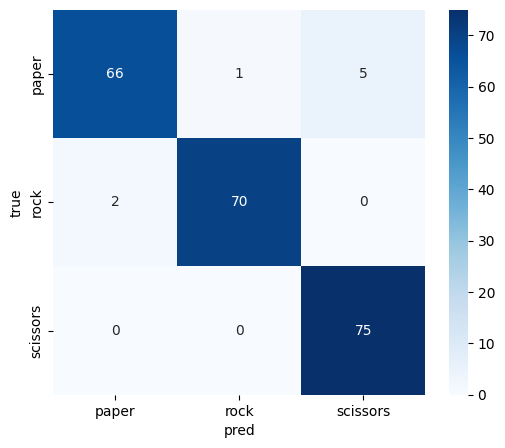

In [31]:
plot_conf_matrix(cm)

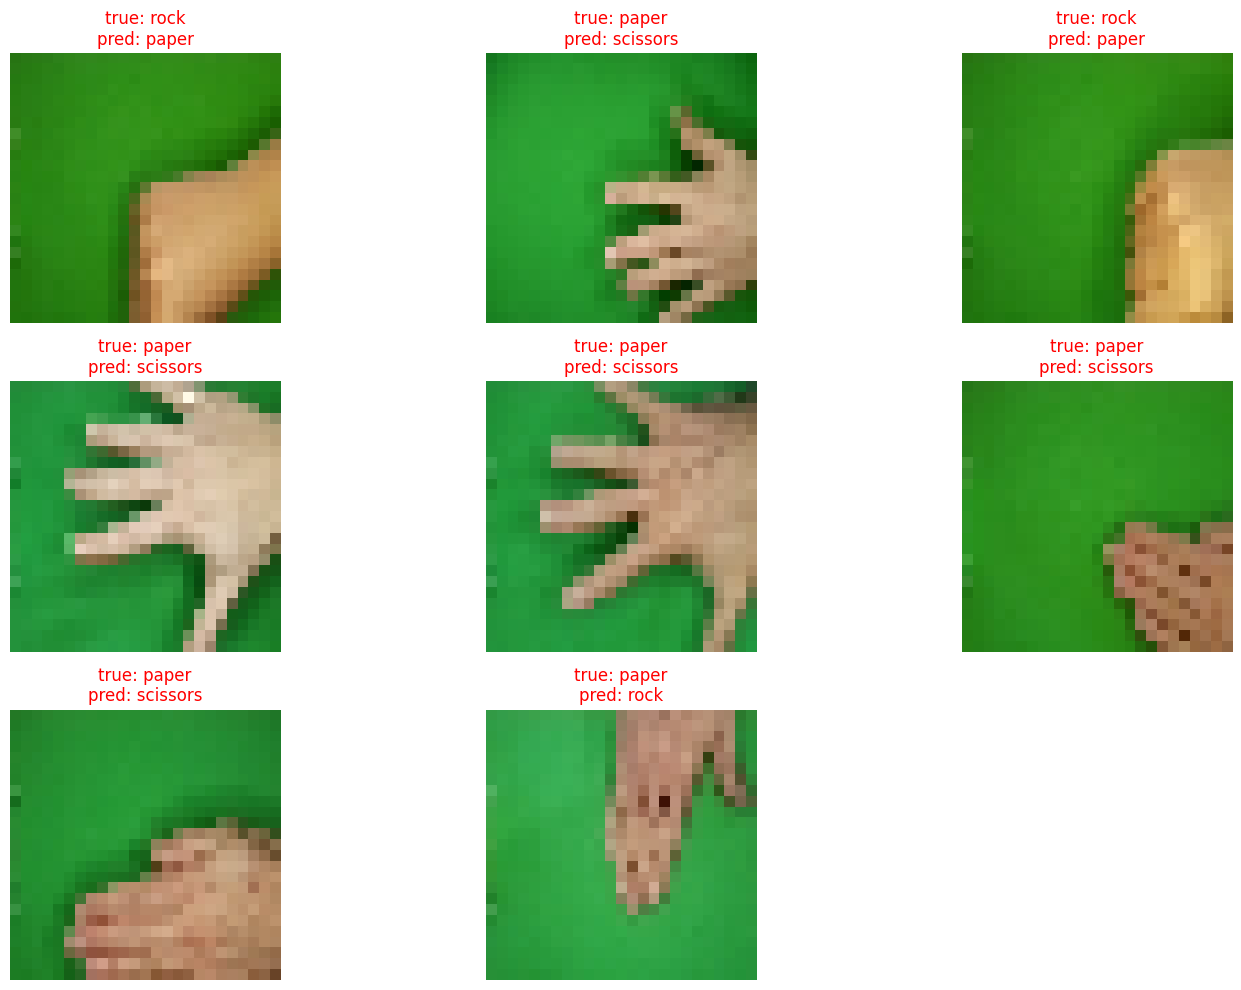

In [62]:
show_misclassified_images(model_first_arch, cv_test_set, class_names)

## Second arch

In [32]:
model_second_arch.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 0.0333  


[0.048995912075042725, 0.9817351698875427]

In [33]:
y_pred = np.argmax(model_second_arch.predict(cv_test_set), axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [34]:
cm = compute_classification_metrics(y_test_array, y_pred, class_names)

              precision    recall  f1-score   support

       paper       1.00      0.94      0.97        72
        rock       0.97      1.00      0.99        72
    scissors       0.97      1.00      0.99        75

    accuracy                           0.98       219
   macro avg       0.98      0.98      0.98       219
weighted avg       0.98      0.98      0.98       219



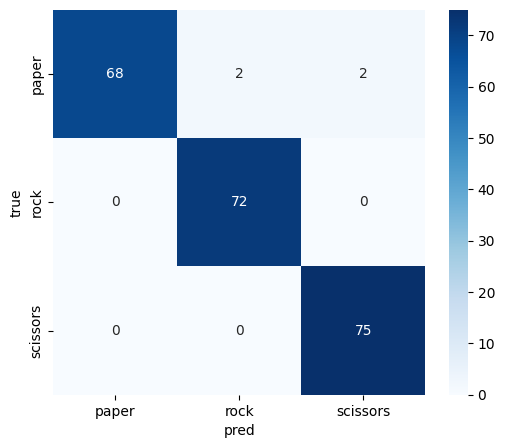

In [35]:
plot_conf_matrix(cm)

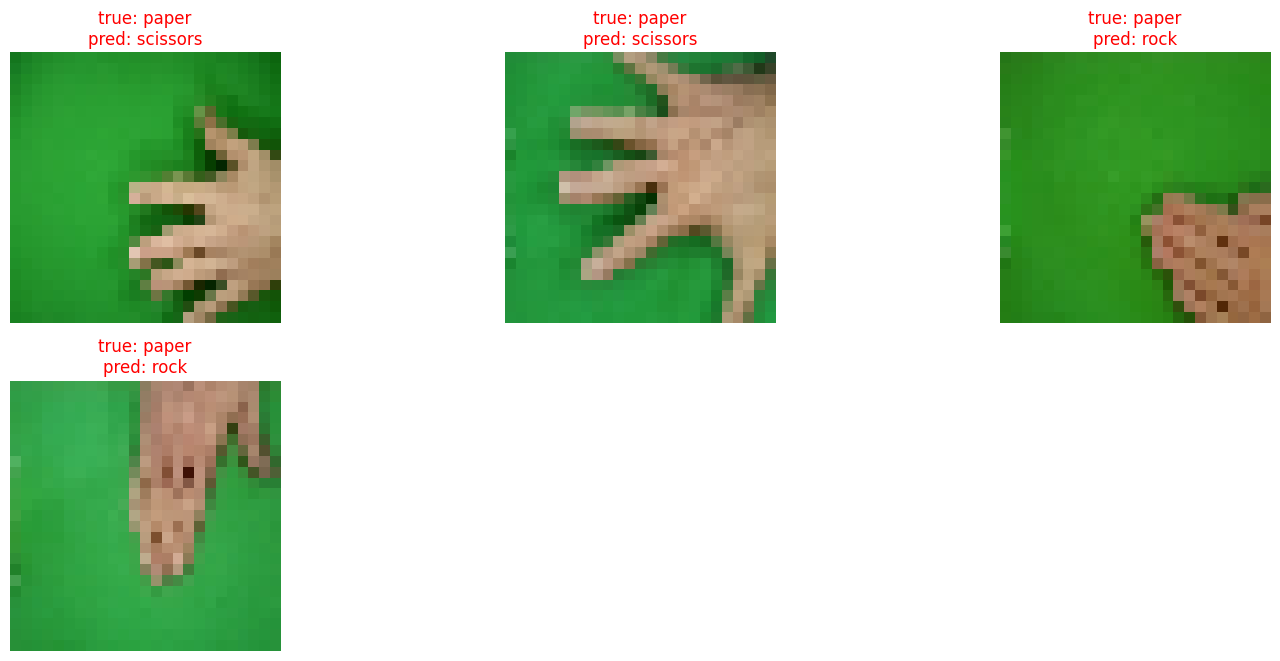

In [36]:
show_misclassified_images(model_second_arch, cv_test_set, class_names)

## Third arch

In [37]:
model_third_arch.evaluate(cv_test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0199  


[0.029822370037436485, 0.9954338073730469]

In [38]:
y_pred = np.argmax(model_third_arch.predict(cv_test_set), axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [39]:
cm = compute_classification_metrics(y_test_array, y_pred, class_names)

              precision    recall  f1-score   support

       paper       1.00      0.99      0.99        72
        rock       0.99      1.00      0.99        72
    scissors       1.00      1.00      1.00        75

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219



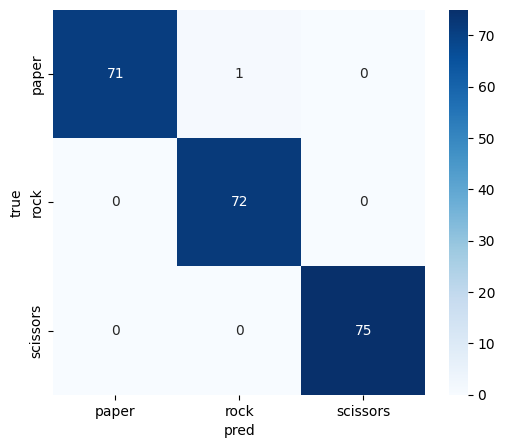

In [40]:
plot_conf_matrix(cm)

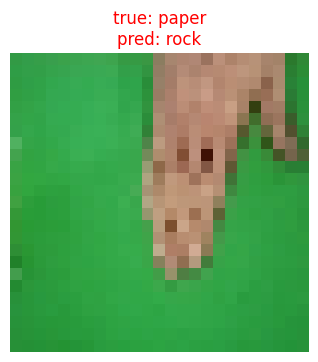

In [73]:
show_misclassified_images(model_third_arch, cv_test_set, class_names)

# Robustness test

In [41]:
# from tensorflow.image import rgb_to_grayscale

In [42]:
original_size = (300,200)
full_dataset = image_dataset_from_directory(
    'C:/Users/faarc/OneDrive/Escritorio/projects/paper_rock_scissors_pr/rock_paper_scissors/rps_deep/generalization_data/diego',
    image_size=image_size,
    label_mode="categorical",
    shuffle=False,
    seed=42
)

Found 11 files belonging to 3 classes.


In [43]:
model_first_arch.evaluate(full_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2727 - loss: 7.0265


[7.026455879211426, 0.27272728085517883]

In [44]:
model_second_arch.evaluate(full_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2727 - loss: 6.3584


[6.358428478240967, 0.27272728085517883]

In [45]:
model_third_arch.evaluate(full_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5455 - loss: 1.5391


[1.539096474647522, 0.5454545617103577]

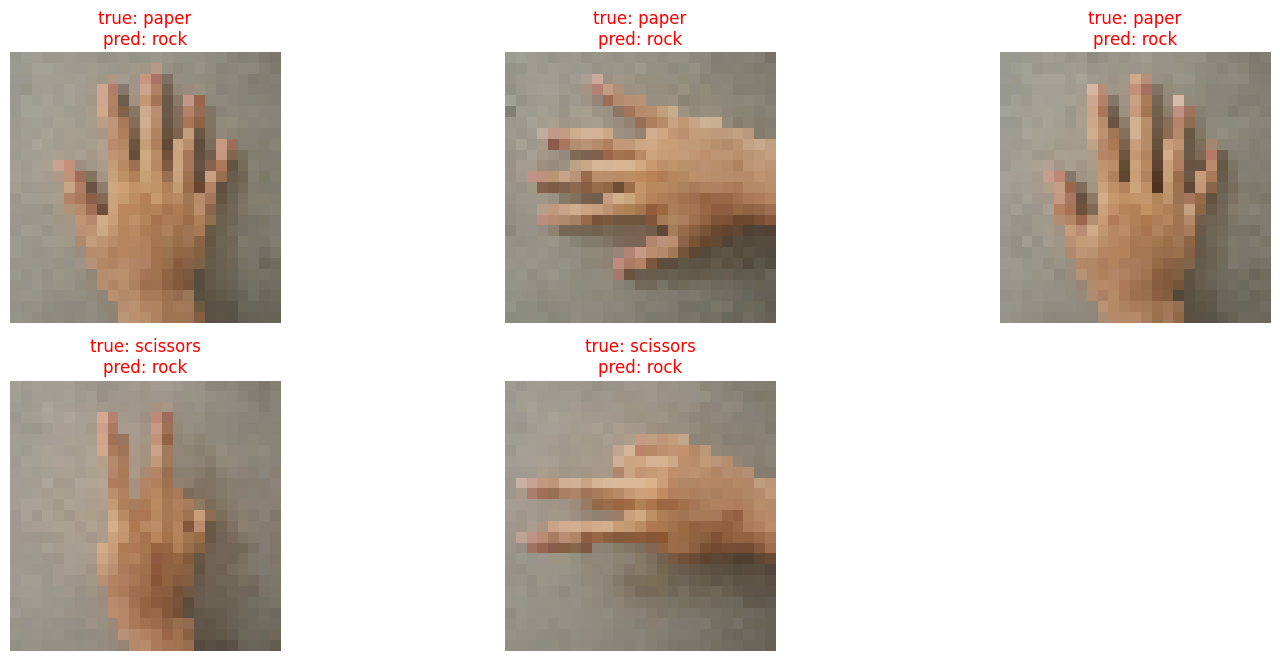

In [46]:
show_misclassified_images(model_third_arch, full_dataset, class_names)